# The Problem

Each week the Consumer Financial Protection Bureau sends thousands of consumer’s complaints about financial product and services to company for a response. Classify those consumer complaints into the product category it belongs to using the description of the complaint.

The goal of this project is to classify the complaint into a specific product category. Since we have multiple categories, this is a multiclass classification problem.

Once the algorithm is in place, whenever there is a new complaint, we can easily classify it and then be redirected to the concerned person. This will save a lot of time because we are minimizing the human interventions to decide whom this complaint should go to.

data source:https://catalog.data.gov/dataset/consumer-complaint-database

data description:https://cfpb.github.io/api/ccdb/fields.html

# Import and Inspect Data

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
import string
from textblob import TextBlob
from nltk.stem import PorterStemmer,SnowballStemmer
from textblob import Word
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [4]:
df = pd.read_csv('complaints.csv', nrows=200000) #limiting number of rows for memory issues

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 200000 non-null  object
 1   Product                       200000 non-null  object
 2   Sub-product                   199612 non-null  object
 3   Issue                         200000 non-null  object
 4   Sub-issue                     175494 non-null  object
 5   Consumer complaint narrative  94597 non-null   object
 6   Company public response       99813 non-null   object
 7   Company                       200000 non-null  object
 8   State                         195741 non-null  object
 9   ZIP code                      195708 non-null  object
 10  Tags                          26462 non-null   object
 11  Consumer consent provided?    173024 non-null  object
 12  Submitted via                 200000 non-null  object
 13 

In [6]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,18640,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,08854,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2019-07-09,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Don't agree with the fees charged,I was contacted about student loan consolidati...,Company believes it acted appropriately as aut...,Equitable Acceptance Corp,TX,75039,NaN,Consent provided,Web,2019-07-09,Closed with explanation,Yes,NaN,3300773
4,2019-08-08,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,Company has responded to the consumer and the ...,"FLAGSTAR BANK, FSB",ID,83706,NaN,NaN,Referral,2019-08-15,Closed with explanation,Yes,NaN,3342290


We won't need all the columns for this problem so I'll only keep the most valuable for now.

In [7]:
df = df[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']]

We could use Sub-product to reduce the number of categories in Product to make the classification problem easier. I'll also rename the columns

In [8]:
df = df.rename(columns={"Product": "product", 
                        "Sub-product": "subproduct", 
                        "Issue": "issue", "Sub-issue": 
                        "subissue", 
                        "Consumer complaint narrative": "narrative"})

In [9]:
print('Values per Category')
print('-'*50)
print(df['product'].value_counts())
print('-'*50)
print('# of unique categories:', df['product'].nunique())

Values per Category
--------------------------------------------------
Credit reporting, credit repair services, or other personal consumer reports    105266
Debt collection                                                                  33437
Credit card or prepaid card                                                      16932
Mortgage                                                                         14893
Checking or savings account                                                      14065
Money transfer, virtual currency, or money service                                4466
Vehicle loan or lease                                                             3769
Student loan                                                                      3703
Payday loan, title loan, or personal loan                                         2612
Bank account or service                                                            263
Credit reporting                                           

We have **17** different category in the dataset, howewver we can see that we some duplicates that I'm going to aggregate.

In [10]:
df['product'].replace({'Credit card':'Credit card or prepaid card',
                       'Prepaid card':'Credit card or prepaid card',
                       'Payday loan':'Payday loan, title loan, or personal loan',
                       'Money transfers':'Money transfer, virtual currency, or money service', 
                       'Consumer Loan':'Payday loan, title loan, or personal loan',  
                       'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports'},
                     inplace = True) 

In [11]:
print('Values per Category')
print('-'*50)
print(df['product'].value_counts())
print('-'*50)
print('# of unique categories:', df['product'].nunique())

Values per Category
--------------------------------------------------
Credit reporting, credit repair services, or other personal consumer reports    105503
Debt collection                                                                  33437
Credit card or prepaid card                                                      17074
Mortgage                                                                         14893
Checking or savings account                                                      14065
Money transfer, virtual currency, or money service                                4505
Vehicle loan or lease                                                             3769
Student loan                                                                      3703
Payday loan, title loan, or personal loan                                         2772
Bank account or service                                                            263
Other financial service                                    

We are down to **11** categories, now let's check subproduct and issue

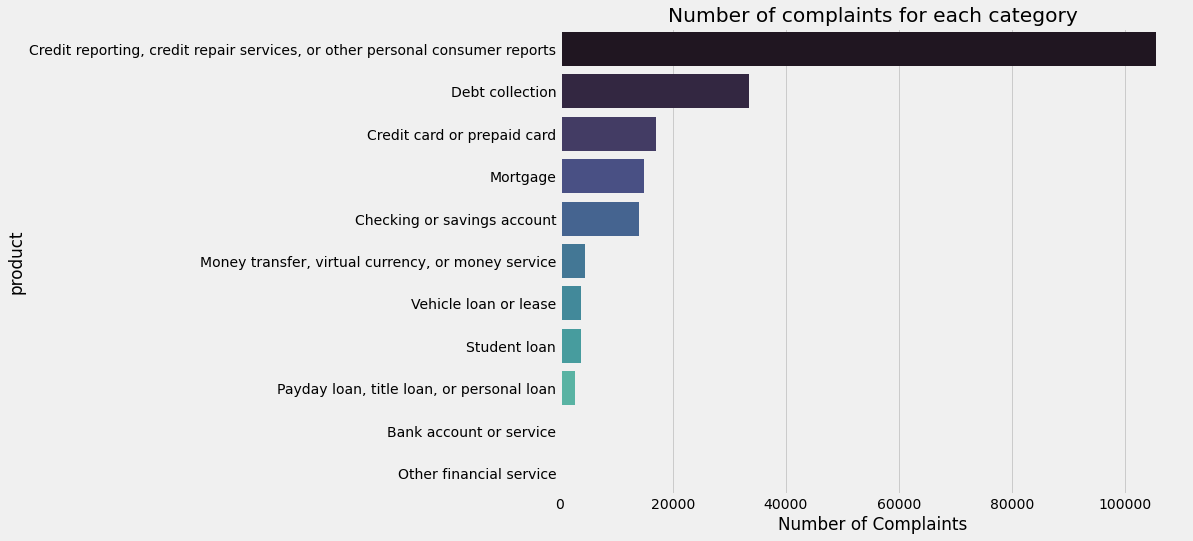

In [12]:
plt.figure(figsize=(10,8))
sns.countplot(y='product', data=df,
             order=df['product'].value_counts().index,
             palette='mako')

plt.xlabel('Number of Complaints')
plt.title('Number of complaints for each category');

In [13]:
pd.set_option("display.max_rows", 100)

In [14]:
df['subproduct'].value_counts()

Credit reporting                              103865
General-purpose credit card or charge card     12679
Checking account                               11168
Conventional home mortgage                      8934
Other debt                                      8620
Credit card debt                                8014
I do not know                                   7597
Medical debt                                    5089
Loan                                            3117
Store credit card                               2587
Federal student loan servicing                  2430
FHA mortgage                                    2292
Mobile or digital wallet                        1689
Other banking product or service                1642
Private student loan                            1230
Auto debt                                       1207
Domestic (US) money transfer                    1145
Installment loan                                1145
Other type of mortgage                        

In [15]:
df['issue'].value_counts()

Incorrect information on your report                                                65727
Problem with a credit reporting company's investigation into an existing problem    28610
Attempts to collect debt not owed                                                   16735
Managing an account                                                                  8830
Improper use of your report                                                          8794
                                                                                    ...  
Account terms and changes                                                               1
Credit reporting                                                                        1
Other fee                                                                               1
Incorrect/missing disclosures or info                                                   1
Shopping for a line of credit                                                           1
Name: issu

In [16]:
df['subissue'].value_counts()

Information belongs to someone else                          42145
Their investigation did not fix an error on your report      16859
Debt is not yours                                             7968
Account status incorrect                                      7891
Account information incorrect                                 7722
                                                             ...  
Incorrect information on your report                             1
Receiving unwanted marketing/advertising                         1
Overdraft charges                                                1
Contacted me instead of my attorney                              1
Was signed up for overdraft on card, but don't want to be        1
Name: subissue, Length: 211, dtype: int64

We can't use subproduct, issue and issue for classification because we have a lot of different values. We also have some null values in the dataframe, I'll just drop them since we have enough data.

## Combine categories and create new dataframes


In [17]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    105503
Debt collection                                                                  33437
Credit card or prepaid card                                                      17074
Mortgage                                                                         14893
Checking or savings account                                                      14065
Money transfer, virtual currency, or money service                                4505
Vehicle loan or lease                                                             3769
Student loan                                                                      3703
Payday loan, title loan, or personal loan                                         2772
Bank account or service                                                            263
Other financial service                                                             16
Name: product, dtype: int64

In [18]:
df[df['product'] == 'Other financial service'].head(16)

,product,subproduct,issue,subissue,narrative
1196,Other financial service,Debt settlement,Fraud or scam,NaN,NaN
3175,Other financial service,Check cashing,Customer service/Customer relations,NaN,NaN
8494,Other financial service,Debt settlement,Disclosures,NaN,NaN
18803,Other financial service,Credit repair,Excessive fees,NaN,NaN
27359,Other financial service,Debt settlement,Disclosures,NaN,"I spoke with XXXX at Lexington Law, I asked fo..."
30196,Other financial service,Credit repair,Fraud or scam,NaN,NaN
32690,Other financial service,Credit repair,Disclosures,NaN,NaN
34911,Other financial service,Debt settlement,Excessive fees,NaN,NaN
35472,Other financial service,Debt settlement,Unexpected/Other fees,NaN,NaN
40680,Other financial service,Credit repair,Disclosures,NaN,NaN


We only have 16 values for other financial service and, as we can see above, this is a residual category. Since we have few values, I'll drop the rows with this product category

In [19]:
df.shape

(200000, 5)

In [20]:
df = df.drop(df[df['product'] == 'Other financial service'].index)

In [21]:
df.shape

(199984, 5)

In [22]:
df['product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    105503
Debt collection                                                                  33437
Credit card or prepaid card                                                      17074
Mortgage                                                                         14893
Checking or savings account                                                      14065
Money transfer, virtual currency, or money service                                4505
Vehicle loan or lease                                                             3769
Student loan                                                                      3703
Payday loan, title loan, or personal loan                                         2772
Bank account or service                                                            263
Name: product, dtype: int64

In [23]:
df[df['product'] == 'Bank account or service'].head(20)

,product,subproduct,issue,subissue,narrative
332,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,NaN
1001,Bank account or service,Checking account,Problems caused by my funds being low,NaN,NaN
1137,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...
1413,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...
2605,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN
2791,Bank account or service,Checking account,"Account opening, closing, or management",NaN,I have problem with the bank checking account ...
3506,Bank account or service,Checking account,Problems caused by my funds being low,NaN,I have a bank account with Wells Fargo that I ...
5552,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN
5702,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN
8323,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,RE : XXXX XXXX MD-PRIVILEGED AND CONFIDENTIAL ...


In [24]:
df[df['product'] == 'Checking or savings account'].head(20)

,product,subproduct,issue,subissue,narrative
11,Checking or savings account,Checking account,Managing an account,Funds not handled or disbursed as instructed,NaN
44,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,NaN
48,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN
57,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,I made a purchase from XXXX XXXX for a XXXX XX...
58,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Can't stop withdrawals from your account,Today I am writing to see if you can help me w...
62,Checking or savings account,Savings account,Problem with a lender or other company chargin...,Transaction was not authorized,Santander Bank took the opening deposit which ...
109,Checking or savings account,Checking account,Managing an account,Banking errors,NaN
141,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,On XX/XX/19 I made a deposit in the amount of ...
144,Checking or savings account,Checking account,Managing an account,Banking errors,NaN
145,Checking or savings account,Checking account,Managing an account,Problem making or receiving payments,NaN


In [25]:
df[df['product'] == 'Money transfer, virtual currency, or money service'].head(20)

,product,subproduct,issue,subissue,narrative
25,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,NaN,"In an attempt to purchase concert tickets, I c..."
75,"Money transfer, virtual currency, or money ser...",International money transfer,Fraud or scam,NaN,XXXX This email is associated with a scammer s...
166,"Money transfer, virtual currency, or money ser...",Virtual currency,Fraud or scam,NaN,This is a XXXX involving stolen identity and f...
289,"Money transfer, virtual currency, or money ser...",International money transfer,Money was not available when promised,NaN,NaN
324,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Other transaction problem,NaN,I attempted to send payment to my landlord via...
342,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Money was not available when promised,NaN,"On XX/XX/2018, I used the XXXX XXXX app to tra..."
362,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,NaN,On XXXX XXXX I sent a wire for XXXX XXXX from ...
366,"Money transfer, virtual currency, or money ser...",International money transfer,Money was not available when promised,NaN,I am an American expatriate living in XXXX XXX...
400,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Other transaction problem,NaN,NaN
443,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Unauthorized transactions or other transaction...,NaN,NaN


We can see that these three categories deal with **retail banking** so I'll aggregate them into this category. I'll also aggregate all the loans in the **loan** category and rename all other categories.

In [26]:
df['product'].replace({'Credit reporting, credit repair services, or other personal consumer reports': 'credit_reporting',
                       'Debt collection': 'debt_collection',
                       'Credit card or prepaid card': 'credit_card',
                       'Mortgage': 'mortgage',
                       'Bank account or service':'retail_banking',
                       'Checking or savings account': 'retail_banking',
                       'Money transfer, virtual currency, or money service': 'retail_banking',
                       'Vehicle loan or lease': 'loans',
                       'Payday loan, title loan, or personal loan': 'loans',
                       'Student loan': 'loans'}, inplace = True)

In [27]:
df['product'].value_counts()

credit_reporting    105503
debt_collection      33437
retail_banking       18833
credit_card          17074
mortgage             14893
loans                10244
Name: product, dtype: int64

Now we only have 6 categories. I also wanto to combine mortgage and loans since mortgage is a kind of loan and these two are right now the classes with less values.

In [28]:
df['product'].replace({'mortgage':'mortgages_and_loans',
                      'loans':'mortgages_and_loans'},
                     inplace = True)

In [29]:
df['product'].value_counts()

credit_reporting       105503
debt_collection         33437
mortgages_and_loans     25137
retail_banking          18833
credit_card             17074
Name: product, dtype: int64

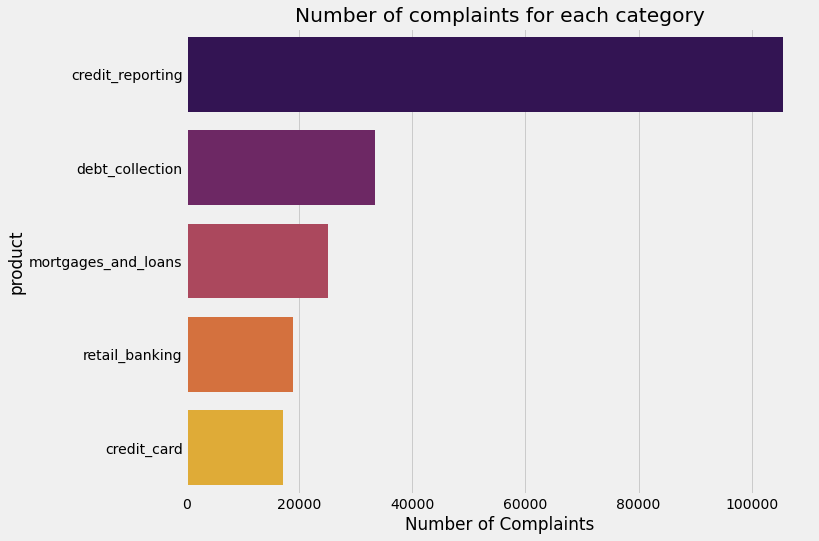

In [30]:
plt.figure(figsize=(10,8))
sns.countplot(y='product', data=df,
             order=df['product'].value_counts().index,
             palette='inferno')

plt.xlabel('Number of Complaints')
plt.title('Number of complaints for each category');

For the classification we will only use product and narrative columns

In [31]:
df = df[['product', 'narrative']]

We need to dropp the null values from the dataframe

In [32]:
df.dropna(axis=0, inplace=True)

In [33]:
df['product'].value_counts()

credit_reporting       46042
debt_collection        17379
mortgages_and_loans    13470
credit_card             9239
retail_banking          8462
Name: product, dtype: int64

Now we need to prepare our data for modelling.

# Text Data Preprocessing 

## Converting Text data to Lowercase

In [34]:
df['narrative'] = df['narrative'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))

In [37]:
df['narrative'].sample(15)

158410    i have been disputing things with the bureaus ...
138681    i am not liable for this debt with xxxx xxxx a...
138478    aargon agency inc is attempting to collect a d...
45729                              wrong name on my report.
177651    i had an auto loan with capital one auto finan...
23511     from the time business account # xxxx and my p...
113018    i mailed santander on xx/xx/2021 and filed my ...
159317    i recently moved to a state where they do not ...
198215    leased ( pre-paid at signing xx/xx/xxxx = " at...
133435    on xx/xx/2019 i received a call and email from...
72278     to whom it may concern, we have a va loan with...
187556    i thought i lost my device so i asked coinbase...
148717    citibank stole over {$30000.00}. i need help. ...
130336    i've had a wells fargo credit card for almost ...
12688     our mortgage was sold to mr. cooper/nationstar...
Name: narrative, dtype: object

We can see that all the text now is in lowercase letters

## Removing Punctuation

In [38]:
df['narrative'] = df['narrative'].str.replace(r'[^\w\s]',"")

In [39]:
df['narrative'].sample(15)

94869     on xxxx2021 sent a letter regarding inaccurate...
81341     i just opened a wells fargo complaint xxxx few...
185134    xxxx xxxx xxxx xxxx xxxx xxxx xxxx ca xxxx bin...
147795    xxxx is my original case number here the credi...
55234     i am a victim of identity theft i contacted th...
137625    xxxxxxxx xxxx xxxx xxxx xxxx xxxx xxxx tx xxxx...
9413      in xxxx of xxxx i made a payment of 6900 to xx...
72308     date  s   xxxxxxxx and xxxxxxxx i recently had...
63884     to whom it may concern the below summary will ...
85111     transworld system  inc cfpb  are you serious t...
14209                 sent ftc and police report to equifax
151534    we received a letter from arstrat claiming we ...
42039     on or about xxxx2012 greynolds sims  associate...
80343     on xxxx2018 someone stole my identify and open...
193551    i have attempted on several occasions to remov...
Name: narrative, dtype: object

## Removing Stopwords

In [40]:
stop = stopwords.words('english')

In [41]:
df['narrative'] = df['narrative'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))

In [42]:
df['narrative'].sample(15)

145463    received two letters day company name trs reco...
47044     accounts still appear credit report part ident...
115631    intentionally defrauded deceptive business pra...
49543     contacted collection agency l j ross well xxxx...
148362    took loan xxxxxxxx help start xxxx xxxx positi...
113447    applied renewal existing helhocl 50000000 appl...
180730    account mine want removed 1 identity theft xxx...
128641    recently checked credit saw company popped rep...
110308    collection agency named transworld systems rep...
120466              account balance incorrect please delete
127379    citizens bank overdraft policy discretion bank...
24451     xxxx2019 xxxx called get response illegal unfa...
174795    name xxxx xxxx purpose complaint regards pnc b...
71542     aforementioned credit agency representing xxxx...
131944    according fair credit reporting act section 60...
Name: narrative, dtype: object

## Lemmatizing

In [44]:
df['narrative']  =df['narrative'].apply(lambda x:' '.join([Word(i).lemmatize() for i in x.split()]))

In [45]:
df['narrative'].sample(15)

70799     name xxxx xxxx xxxx issue inaccurate address c...
18634     opened first mortgage house loan servicing com...
85643     trying work equifax answer identity question u...
145603    im disputing account im asking prove 100 verif...
161320    making extra payment early payment theyre cred...
139003    delay recording trustee sale manipulation item...
154602    called explained hardship company said could h...
161782    owner xxxx xxxx xxxx address xxxx xxxx xxxx xx...
196579    disputed account inquiry hindering credit affe...
148707    early last year saw hard inquiry credit report...
28688     equifax reporting inaccurate data xxxx xxxx xx...
52657     xxxx2020 sent letter regarding inaccurate unkn...
74079     mortgage service provider reporting ontime pay...
54250     chargeoff american express approximately 16000...
94607     summary believe bank america engaging unethica...
Name: narrative, dtype: object

In [48]:
#Removing xs
df['narrative'] = df['narrative'].str.replace(r"xx+\s","")

In [49]:
df['narrative'].sample(15)

72238     filed bankruptcy discharged submitted record a...
141612    medical debt put collection requested validati...
170032    despite previous query letter department recen...
182875    equifax incorrectly reporting collection amoun...
165905    never authorized company pull credit never eve...
14171                       paid full keep switching lender
14943       noticed inquires well fargo credit report didnt
79770     cbc debt collection agency stated balance 8000...
186533    two 2 fedloans opened used information cosigne...
84896     information hacked obtained someway checked cr...
109881    continues ignore dispute fix problem repeatedl...
109606    debt placed credit report knowledge ive never ...
61066     enrolled paperless billing never received aler...
98324     u bank reward credit scheduled auto pay every ...
21022     transunion credit reporting agency removed mor...
Name: narrative, dtype: object

## Word Clouds

mortgages_and_loans


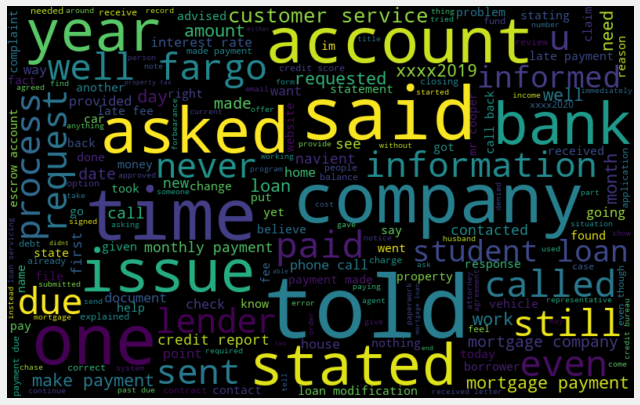

credit_reporting


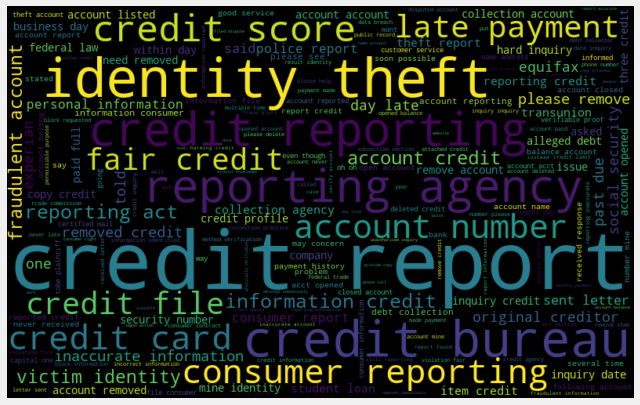

credit_card


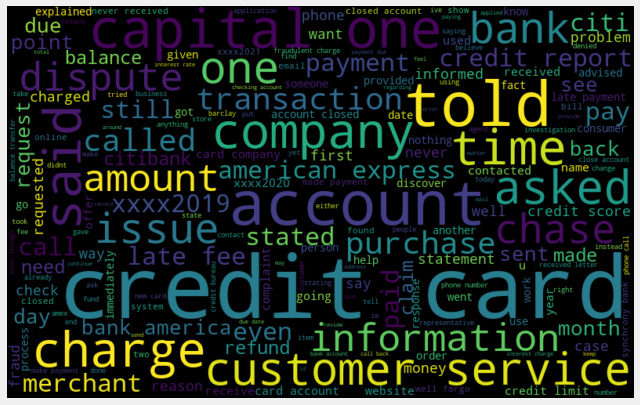

retail_banking


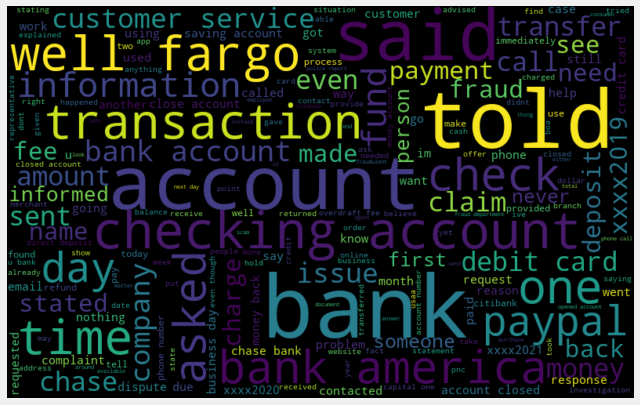

debt_collection


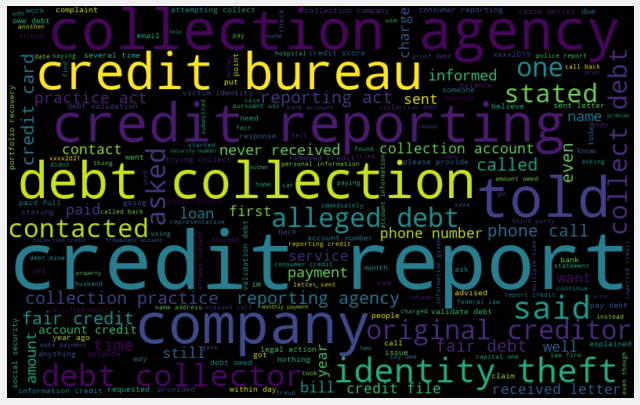

In [50]:
for product_name in df['product'].unique():
    print(product_name)
    all_words = ' '.join([text for text in df.loc[df['product'].str.contains(product_name),'narrative']])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Preparing the data

First I need to convert the different categories into numbers, I'll use LabelEncoder.

In [51]:
encoder = LabelEncoder()

df['product_enc'] = encoder.fit_transform(df['product'])
Labels = encoder.fit_transform(df['product'])
Labels

array([3, 3, 1, ..., 1, 1, 1])

In [52]:
df.head()

,product,narrative,product_enc
1,mortgages_and_loans,contacted ally friday falling behind payment d...,3
3,mortgages_and_loans,contacted student loan consolidation agreed co...,3
5,credit_reporting,hello complaint three credit reporting company...,1
6,credit_reporting,victim identity theft currently experian accou...,1
7,credit_reporting,virginia investigation still open dispute open...,1


## Train test split

In [53]:
#train test split 
X_train, X_test, y_train, y_test = train_test_split(df['narrative'], df['product_enc'], random_state= 42)

## Text processing with TF-IDF

In [54]:
tfidf = TfidfVectorizer(sublinear_tf= True, #use a logarithmic form for frequency
                       min_df = 5, #minimum numbers of documents a word must be present in to be kept
                       norm= 'l2', #ensure all our feature vectors have a euclidian norm of 1
                       ngram_range= (1,2), #to indicate that we want to consider both unigrams and bigrams.
                       stop_words ='english') #to remove all common pronouns to reduce the number of noisy features

In [55]:
#fit transform for train set
X_train_tfidf = tfidf.fit_transform(X_train)

#Transform for test set to avoid data leakeage
X_test_tfidf = tfidf.transform(X_test)

Now we are ready to build some models

# Model Building

Let's start with a simple model

## Bernoulli NB

In [56]:
bnb = BernoulliNB()

#train the model
bnb.fit(X_train_tfidf, y_train)

BernoulliNB()

In [57]:
#cv score
cv_results = cross_val_score(bnb,
                             X_train_tfidf, y_train, 
                             cv=5,
                             scoring="accuracy",
                             n_jobs=-1)
print(np.mean(cv_results))

0.7854223222311753


In [58]:
#make predictions
y_pred = bnb.predict(X_test_tfidf)

#Evaluate the model
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy: ",accuracy)

print(classification_report(y_test, y_pred, target_names=df['product'].unique()))

Accuracy:  0.7924137347767253
                     precision    recall  f1-score   support

mortgages_and_loans       0.67      0.68      0.68      2321
   credit_reporting       0.82      0.86      0.84     11533
        credit_card       0.78      0.67      0.72      4389
     retail_banking       0.76      0.78      0.77      3323
    debt_collection       0.82      0.81      0.81      2082

           accuracy                           0.79     23648
          macro avg       0.77      0.76      0.77     23648
       weighted avg       0.79      0.79      0.79     23648



The performance are not great with an overall accuracy of **0.792**.From the classification report we can also see that the credit_card category has a recall of 0.66 and the mortgages_and_loans (the class with less support) is not very good.

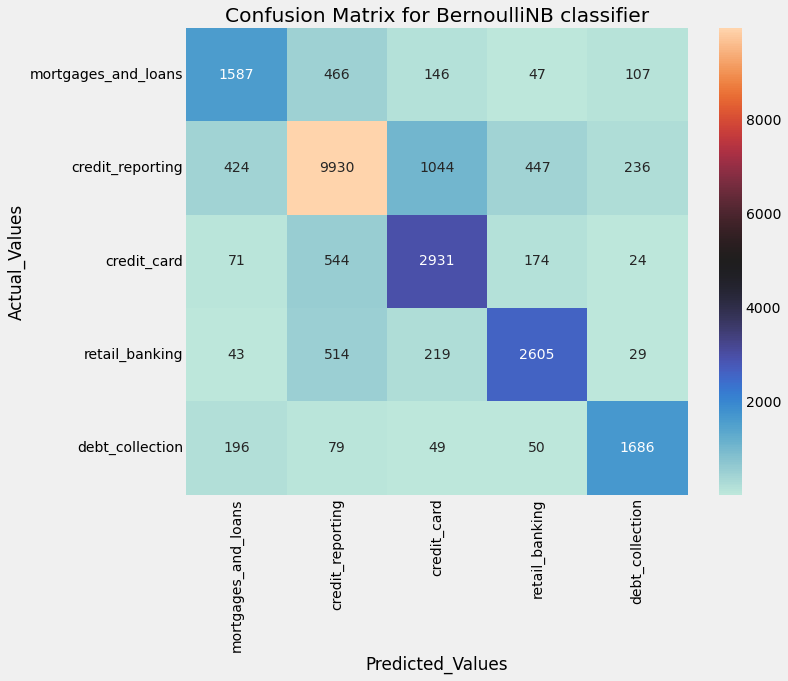

In [59]:
#Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_pred, y_test)

#Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap='icefire',
            xticklabels=df['product'].unique(),
            yticklabels=df['product'].unique())
plt.ylabel('Actual_Values')
plt.xlabel('Predicted_Values')
plt.title('Confusion Matrix for BernoulliNB classifier');

This model does pretty well at classifing credit_reporting, which is expected since it is the most represented class, however mortgages_and_loans, credit_card and retail_banking have a lot of missclassified values.

## Linear SVC

In [60]:
svc = LinearSVC()
svc.fit(X_train_tfidf, y_train)

LinearSVC()

In [61]:
#cv score
cv_results = cross_val_score(svc,
                             X_train_tfidf, y_train, 
                             cv=5,
                             scoring="accuracy",
                             n_jobs=-1)
print(np.mean(cv_results))

0.8668104576298428


In [62]:
#make predictions
y_pred = svc.predict(X_test_tfidf)

#Evaluate the model
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy: ",accuracy)

print(classification_report(y_test, y_pred, target_names=df['product'].unique()))

Accuracy:  0.8704753044654939
                     precision    recall  f1-score   support

mortgages_and_loans       0.81      0.78      0.79      2321
   credit_reporting       0.90      0.92      0.91     11533
        credit_card       0.83      0.79      0.81      4389
     retail_banking       0.85      0.85      0.85      3323
    debt_collection       0.86      0.89      0.88      2082

           accuracy                           0.87     23648
          macro avg       0.85      0.85      0.85     23648
       weighted avg       0.87      0.87      0.87     23648



We can see that we have pretty good performance already with an overall accuracy of **0.870**. In the classification record we can see that even for classes with less support have good score.

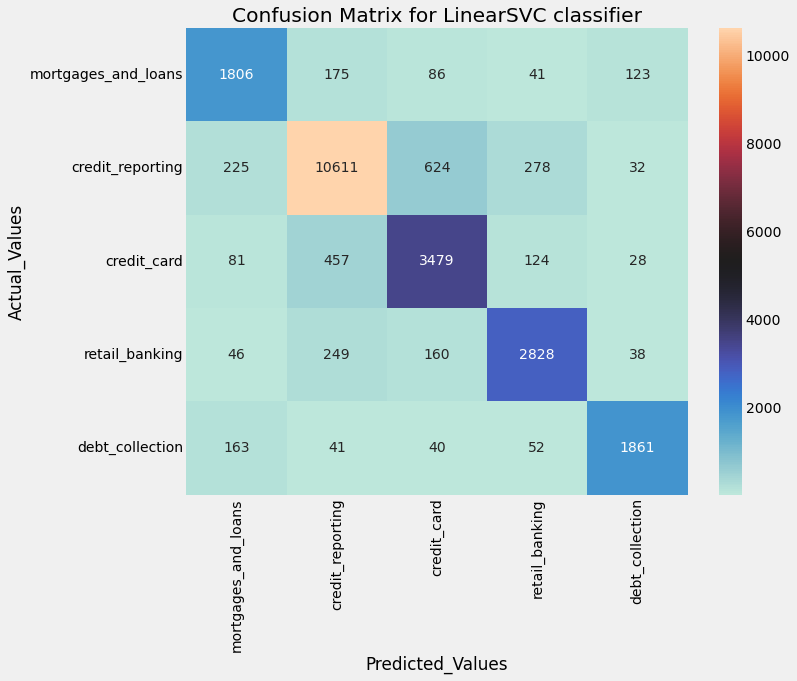

In [63]:
#Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_pred, y_test)

#Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap='icefire',
            xticklabels=df['product'].unique(),
            yticklabels=df['product'].unique())
plt.ylabel('Actual_Values')
plt.xlabel('Predicted_Values')
plt.title('Confusion Matrix for LinearSVC classifier');

From the confusion matrix we can see that sometimes credit_card and credit_reporting are missclassified with each other; retail_banking too get sometimes missclassified as redit_reporting. 

Now let's try another model.

## Logistic Regression

In [64]:
lgt = LogisticRegression()

#train the model
lgt.fit(X_train_tfidf, y_train)

LogisticRegression()

In [65]:
cv_results = cross_val_score(svc,
                             X_train_tfidf, y_train, 
                             cv=5,
                             scoring="accuracy",
                             n_jobs=-1)
print(np.mean(cv_results))

0.8668104576298428


In [66]:
#make predictions
y_pred = lgt.predict(X_test_tfidf)

#Evaluate the model
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy: ",accuracy)

print(classification_report(y_test, y_pred, target_names=df['product'].unique()))

Accuracy:  0.8644282814614344
                     precision    recall  f1-score   support

mortgages_and_loans       0.82      0.77      0.79      2321
   credit_reporting       0.89      0.92      0.90     11533
        credit_card       0.83      0.78      0.80      4389
     retail_banking       0.84      0.85      0.85      3323
    debt_collection       0.87      0.89      0.88      2082

           accuracy                           0.86     23648
          macro avg       0.85      0.84      0.84     23648
       weighted avg       0.86      0.86      0.86     23648



Logistic regression performs sligthly worse and we get an overall accuracy of **0.864**

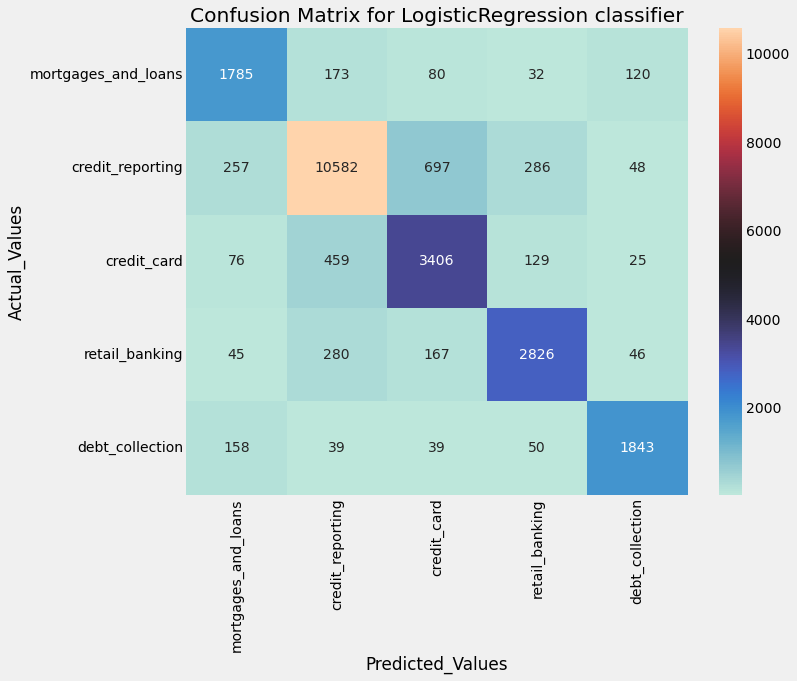

In [67]:
#Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_pred, y_test)

#Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap='icefire',
            xticklabels=df['product'].unique(),
            yticklabels=df['product'].unique())
plt.ylabel('Actual_Values')
plt.xlabel('Predicted_Values')
plt.title('Confusion Matrix for LogisticRegression classifier');

From the confusion matrix we can see that the errors are the same, but the overall performance is worse.

The best model seems to be LinearSVC. We could try more complex models like RandomForestRegressor or XGBoost but I ran into memory issues. We can try to optimize the **C** hyperparametr for LinearSVC regressor and see if the performance improves but I still run into memory issues with my pc.